# Рекомендательные системы: Content-based (TF-IDF + Cosine) и Collaborative Filtering + рекомендации фильмов

---

## Что вы научитесь делать
✅ понимать, зачем нужны рекомендательные системы и какие бывают задачи  
✅ строить **контентные рекомендации**: TF‑IDF → cosine similarity → “похожие фильмы”  
✅ строить **коллаборативные рекомендации**: user-item матрица → similarity → “фильмы для пользователя”  
✅ понимать проблемы **cold start**, разреженности и “пузыря фильтров”  
✅ собрать итоговую функцию `recommend_for_user(...)`

> Примечание: Мы используем небольшой учебный датасет, чтобы всё было **просто и понятно**.  
На Kaggle/реальных данных шаги будут те же, только таблицы больше.


In [18]:
# Если запускаете локально:
# !pip install pandas numpy scikit-learn matplotlib joblib --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import joblib

np.random.seed(42)
print("Ready ✅")

Ready ✅


# 1) Что такое рекомендательная система?

Рекомендательная система — это модель/алгоритм, который предлагает пользователю “что посмотреть/купить/прочитать дальше”.

## Примеры
- YouTube: “следующее видео”
- Netflix: “похожие фильмы”
- Spotify: “плейлист недели”
- Интернет-магазин: “вместе покупают”
- Соцсети: “похожие аккаунты”

---

## Какие задачи решают рекомендации?
1) **Ранжирование**: отсортировать товары/фильмы от самых подходящих  
2) **Похожие элементы**: “похожие фильмы на этот”  
3) **Персонализация**: “под тебя”  
4) **Удержание**: чтобы пользователь оставался дольше  
5) **Продажи**: увеличить средний чек и повторные покупки

---

## Два классических подхода
### A) Content-based (по контенту)
Рекомендуем фильмы, похожие **по описанию/жанрам/ключевым словам**.

### B) Collaborative filtering (коллаборативная фильтрация)
Рекомендуем из поведения пользователей:  
“если пользователи A и B похожи, и A смотрел фильм X, то B тоже может захотеть X”.


# 2) Данные: мини-датасет фильмов (контент)

В реальном проекте фильмы обычно имеют:
- title (название)
- genres (жанры)
- overview / plot (описание)
- keywords / cast / director (дополнительные признаки)

Мы сделаем маленькую таблицу `movies`:
- `title`
- `genres`
- `overview` (короткое описание)

Затем создадим “текстовую фичу” `text = genres + overview`.


In [3]:
movies = pd.DataFrame([
    {"movie_id": 1,  "title": "Space Rescue", "genres": "Sci-Fi Adventure",
     "overview": "A crew travels through space to rescue a lost astronaut and face unknown aliens."},
    {"movie_id": 2,  "title": "Robot Heart", "genres": "Sci-Fi Drama",
     "overview": "An engineer builds a robot that learns emotions and questions what it means to be human."},
    {"movie_id": 3,  "title": "Love in Paris", "genres": "Romance Comedy",
     "overview": "Two strangers meet in Paris and fall in love through a series of funny accidents."},
    {"movie_id": 4,  "title": "Detective Night", "genres": "Crime Thriller",
     "overview": "A detective investigates a mysterious murder case with shocking twists."},
    {"movie_id": 5,  "title": "Jungle Quest", "genres": "Adventure Family",
     "overview": "A family explores a wild jungle to find a legendary treasure and make new friends."},
    {"movie_id": 6,  "title": "Haunted Manor", "genres": "Horror Mystery",
     "overview": "A group of friends enter a haunted mansion and uncover a dark secret."},
    {"movie_id": 7,  "title": "City Chef", "genres": "Comedy Drama",
     "overview": "A young chef fights for success in a big city restaurant and learns teamwork."},
    {"movie_id": 8,  "title": "Galaxy War", "genres": "Sci-Fi Action",
     "overview": "A rebellion battles an empire across the galaxy using spaceships and strategy."},
    {"movie_id": 9,  "title": "Deep Ocean", "genres": "Documentary Nature",
     "overview": "Scientists explore deep ocean creatures and discover new species."},
    {"movie_id": 10, "title": "The Last Kingdom", "genres": "History Action",
     "overview": "A warrior defends a kingdom in ancient times against invaders and betrayal."},
    {"movie_id": 11, "title": "Funny Neighbors", "genres": "Comedy",
     "overview": "Neighbors start a prank war that turns into an unexpected friendship."},
    {"movie_id": 12, "title": "Code Breakers", "genres": "Crime Drama",
     "overview": "Analysts track cyber criminals and solve a major data breach case."},
], columns=["movie_id", "title", "genres", "overview"])

movies["text"] = (movies["genres"].fillna("") + " " + movies["overview"].fillna("")).str.lower()

movies.head()

,movie_id,title,genres,overview,text
0,1,Space Rescue,Sci-Fi Adventure,A crew travels through space to rescue a lost ...,sci-fi adventure a crew travels through space ...
1,2,Robot Heart,Sci-Fi Drama,An engineer builds a robot that learns emotion...,sci-fi drama an engineer builds a robot that l...
2,3,Love in Paris,Romance Comedy,Two strangers meet in Paris and fall in love t...,romance comedy two strangers meet in paris and...
3,4,Detective Night,Crime Thriller,A detective investigates a mysterious murder c...,crime thriller a detective investigates a myst...
4,5,Jungle Quest,Adventure Family,A family explores a wild jungle to find a lege...,adventure family a family explores a wild jung...


# 3) Content-based рекомендации: TF‑IDF + Cosine similarity

## 3.1 TF‑IDF
TF‑IDF превращает текст в числа.

- **TF** (частота слова в документе)  
- **IDF** (редкость слова по всем документам)

Смысл:
- частые “служебные слова” получают маленький вес
- важные редкие слова получают большой вес

---

## 3.2 Cosine similarity (косинусная близость)
Когда у нас есть два вектора (например, два фильма как TF‑IDF вектора),  
мы можем измерить похожесть:

- 1.0 → очень похожи
- 0.0 → почти не похожи
- иногда бывает <0, но для TF‑IDF обычно ≥ 0

Cosine similarity смотрит **угол между векторами**, а не длину.


In [19]:
tfidf = TfidfVectorizer(stop_words=None)
X_tfidf = tfidf.fit_transform(movies["text"])

print("TF-IDF matrix shape:", X_tfidf.shape)  # (n_movies, vocab_size)

TF-IDF matrix shape: (12, 124)


In [20]:
# Матрица похожести фильмов друг на друга
sim_matrix = cosine_similarity(X_tfidf)

sim_df = pd.DataFrame(sim_matrix, index=movies["title"], columns=movies["title"])
sim_df.iloc[:5, :5]

title,Space Rescue,Robot Heart,Love in Paris,Detective Night,Jungle Quest
title,,,,,
Space Rescue,1.000000,0.141182,0.067370,0.0,0.112532
Robot Heart,0.141182,1.000000,0.011375,0.0,0.052040
Love in Paris,0.067370,0.011375,1.000000,0.0,0.011603
Detective Night,0.000000,0.000000,0.000000,1.0,0.000000
Jungle Quest,0.112532,0.052040,0.011603,0.0,1.000000


## 3.3 Функция “похожие фильмы на этот”

Алгоритм:
1) берём выбранный фильм  
2) смотрим его строку в матрице similarity  
3) сортируем по убыванию  
4) возвращаем Top-N (кроме самого себя)


In [21]:
def recommend_similar_movies(title: str, top_n: int = 5):
    if title not in sim_df.index:
        raise ValueError("Такого title нет в movies. Проверьте название.")

    scores = sim_df[title].sort_values(ascending=False)
    scores = scores.drop(title)  # убираем сам фильм
    return scores.head(top_n)

recommend_similar_movies("Space Rescue", top_n=5)

,Space Rescue
title,
Robot Heart,0.141182
Jungle Quest,0.112532
Galaxy War,0.109753
Love in Paris,0.067370
Deep Ocean,0.014923


In [22]:
# Пример: какие фильмы похожи на "Galaxy War"?
recommend_similar_movies("Galaxy War", top_n=5)

,Galaxy War
title,
Robot Heart,0.145590
Space Rescue,0.109753
The Last Kingdom,0.081776
Funny Neighbors,0.053669
Deep Ocean,0.015389


## 3.4 Визуализация

Покажем “тепловую карту” похожести для нескольких фильмов.


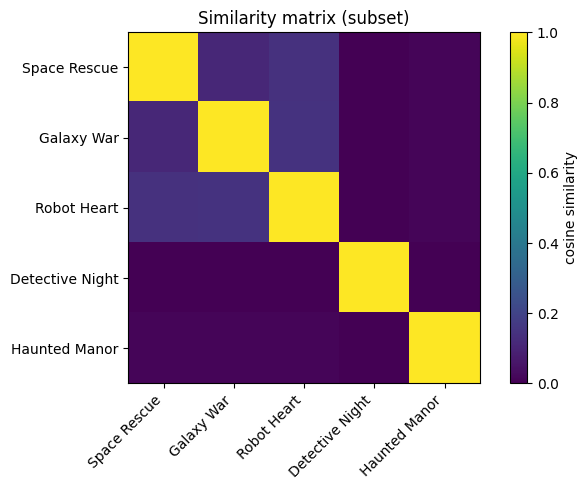

In [23]:
subset = ["Space Rescue", "Galaxy War", "Robot Heart", "Detective Night", "Haunted Manor"]
mini = sim_df.loc[subset, subset]

plt.figure(figsize=(7,5))
plt.imshow(mini.values)
plt.xticks(range(len(subset)), subset, rotation=45, ha="right")
plt.yticks(range(len(subset)), subset)
plt.colorbar(label="cosine similarity")
plt.title("Similarity matrix (subset)")
plt.tight_layout()
plt.show()

# 4) Collaborative filtering (коллаборативная фильтрация)

Content-based работает, даже если у нас 1 пользователь.  
Но часто компании хотят: **персонализировать** по поведению.

Коллаборативная фильтрация использует таблицу:
- строки: пользователи
- столбцы: фильмы
- значения: рейтинг/просмотр/лайк (число)

Эта таблица называется **user-item matrix**.

---

## Проблемы реального мира
- матрица очень разреженная (много пропусков)
- нужно бороться с cold start:
  - новый пользователь без истории
  - новый фильм без оценок


## 4.1 Учебные рейтинги пользователей

Сгенерируем небольшой датасет рейтингов:
- `user_id`
- `movie_id`
- `rating` (1..5)

В реальности это был бы MovieLens или данные стриминга.


In [24]:
users = [f"user_{i}" for i in range(1, 26)]  # 25 пользователей

# Немного "предпочтений" по жанрам (чтобы были закономерности)
genre_bias = {
    "Sci-Fi":  1.0,
    "Action":  0.7,
    "Crime":   0.5,
    "Comedy":  0.2,
    "Romance": 0.2,
    "Horror":  0.1,
    "Nature":  0.1,
    "History": 0.3,
    "Family":  0.2,
    "Drama":   0.4,
    "Documentary": 0.1,
    "Thriller": 0.3,
    "Mystery": 0.3,
    "Adventure": 0.3,
}

def movie_base_score(genres: str):
    score = 0.0
    for g in genres.split():
        score += genre_bias.get(g, 0.0)
    return score

ratings = []
for u in users:
    # каждый пользователь оценивает случайные 5-9 фильмов
    n_rated = np.random.randint(5, 10)
    movie_ids = np.random.choice(movies["movie_id"], size=n_rated, replace=False)
    for mid in movie_ids:
        g = movies.loc[movies["movie_id"] == mid, "genres"].values[0]
        base = 2.5 + movie_base_score(g) + np.random.normal(0, 0.6)
        rating = np.clip(base, 1.0, 5.0)
        ratings.append((u, mid, float(np.round(rating, 1))))

ratings_df = pd.DataFrame(ratings, columns=["user_id", "movie_id", "rating"])

ratings_df.head(), ratings_df.shape


(  user_id  movie_id  rating
 0  user_1        10     3.7
 1  user_1        12     2.8
 2  user_1         1     3.8
 3  user_1         4     3.2
 4  user_1         6     2.9,
 (169, 3))

In [25]:
# user-item матрица
user_item = ratings_df.pivot_table(index="user_id", columns="movie_id", values="rating")
user_item.head()

movie_id,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
user_1,3.8,3.8,2.6,3.2,NaN,2.9,NaN,NaN,2.4,3.7,NaN,2.8
user_10,4.5,4.2,NaN,NaN,2.7,NaN,3.4,NaN,NaN,2.0,NaN,NaN
user_11,3.3,NaN,NaN,NaN,3.1,3.5,NaN,3.8,NaN,NaN,NaN,4.0
user_12,3.2,5.0,NaN,NaN,2.6,NaN,3.4,NaN,2.9,NaN,3.1,2.7
user_13,4.3,3.4,2.9,NaN,2.5,3.4,4.0,NaN,2.9,3.5,NaN,3.6


## 4.2 Как делать рекомендации в Collaborative Filtering?

Есть разные способы, мы начнём с самого понятного:

### Item-based CF (похожесть фильмов по рейтингам)
Идея:
- фильм A и фильм B похожи, если их ставят похожими оценками похожие пользователи

Шаги:
1) берем матрицу user-item
2) заменяем пропуски на 0 (в учебном варианте)
3) считаем cosine similarity между **столбцами** (фильмами)
4) рекомендуем пользователю фильмы, похожие на те, которые он любит

> Это очень понятная базовая версия.
В больших системах используют более сложные подходы (ALS, факторизация, нейросети).


In [26]:
# Заполним NaN нулями: "нет рейтинга"
user_item_filled = user_item.fillna(0.0)

# cosine similarity между фильмами по рейтингам пользователей
# для этого нужны вектора фильмов (столбцы), поэтому делаем transpose
item_sim = cosine_similarity(user_item_filled.T)

item_sim_df = pd.DataFrame(item_sim, index=user_item_filled.columns, columns=user_item_filled.columns)
item_sim_df.iloc[:5, :5]

movie_id,1,2,3,4,5
movie_id,,,,,
1,1.000000,0.599940,0.526875,0.569132,0.841971
2,0.599940,1.000000,0.507107,0.430547,0.582650
3,0.526875,0.507107,1.000000,0.466980,0.426749
4,0.569132,0.430547,0.466980,1.000000,0.457997
5,0.841971,0.582650,0.426749,0.457997,1.000000


## 4.3 Рекомендации “для пользователя” (item-based)

Простейший алгоритм:
1) берём фильмы, которые пользователь оценил высоко (например ≥ 4.0)
2) для каждого такого фильма находим похожие
3) суммируем score (весим по оценке)
4) предлагаем top-N, исключив уже просмотренные


In [27]:
movie_id_to_title = dict(zip(movies["movie_id"], movies["title"]))
title_to_movie_id = dict(zip(movies["title"], movies["movie_id"]))


def recommend_for_user_item_based(user_id: str, top_n: int = 5, like_thr: float = 4.0):
    if user_id not in user_item_filled.index:
        raise ValueError("Такого user_id нет")

    user_ratings = user_item_filled.loc[user_id]
    liked = user_ratings[user_ratings >= like_thr]

    if liked.empty:
        return pd.Series(dtype=float)

    scores = pd.Series(0.0, index=user_item_filled.columns)

    for mid, r in liked.items():
        scores += item_sim_df[mid] * r  # весим похожесть на оценку

    # не рекомендуем то, что уже оценено (любой рейтинг > 0)
    already = user_ratings[user_ratings > 0].index
    scores = scores.drop(already, errors="ignore")

    scores = scores.sort_values(ascending=False).head(top_n)
    scores.index = scores.index.map(movie_id_to_title)
    return scores

# пример для конкретного пользователя
some_user = user_item_filled.index[0]
print("User:", some_user)
recommend_for_user_item_based(some_user, top_n=5)

User: user_1


,0


In [28]:
# Проверим другого пользователя
some_user = user_item_filled.index[7]
print("User:", some_user)
recommend_for_user_item_based(some_user, top_n=5)

User: user_16


,0
movie_id,
Robot Heart,5.721235
Jungle Quest,5.105844
Space Rescue,4.844515
The Last Kingdom,4.135735
Love in Paris,3.130822


# 5) Сравнение подходов: Content-based vs Collaborative

### Content-based
✅ работает без рейтингов (можно только по описаниям)  
✅ хорошо объясняется: “потому что жанр/слова похожи”  
⚠️ плохо персонализирует (всем одинаково “похожие фильмы”)

### Collaborative filtering
✅ персонализация сильная  
✅ ловит скрытые закономерности “людям нравится вместе”  
⚠️ нужен лог пользователей (история просмотров/оценок)  
⚠️ cold start проблема

---

## Гибридный подход
В реальных проектах часто делают “микс”:
- похожие фильмы (content)
- плюс персонализация (collab)


# 6) Итоговый мини‑проект: “рекомендации фильмов” от начала до конца

Сделаем 2 функции:
- `recommend_similar_movies(title)` — похожие фильмы по контенту
- `recommend_for_user_item_based(user_id)` — рекомендации для пользователя по коллаборативной фильтрации

И добавим “универсальную” функцию:
- если пользователь новый → content-based по выбранному фильму
- иначе → collaborative


In [29]:
def recommend(user_id=None, title=None, top_n=5):
    # если есть пользователь и у него есть рейтинги → персональные рекомендации
    if user_id is not None and user_id in user_item_filled.index:
        recs = recommend_for_user_item_based(user_id, top_n=top_n)
        if len(recs) > 0:
            return ("collaborative", recs)

    # fallback: похожие фильмы на выбранный title
    if title is None:
        title = movies["title"].iloc[0]  # если ничего не дали — возьмём первый
    return ("content", recommend_similar_movies(title, top_n=top_n))

method, recs = recommend(user_id="user_3", title="Space Rescue", top_n=5)
print("Method:", method)
recs

Method: content


,Space Rescue
title,
Robot Heart,0.141182
Jungle Quest,0.112532
Galaxy War,0.109753
Love in Paris,0.067370
Deep Ocean,0.014923


In [15]:
method, recs = recommend(user_id="new_user", title="Detective Night", top_n=5)
print("Method:", method)
recs

Method: content


,Detective Night
title,
Code Breakers,0.149933
Robot Heart,0.000000
Space Rescue,0.000000
Love in Paris,0.000000
Jungle Quest,0.000000


# 7) Сохранение моделей

Мы можем сохранить:
- TF‑IDF vectorizer
- similarity matrix (content)
- item similarity matrix (collab)

Такое часто делают, чтобы не пересчитывать каждый раз.


In [30]:
SAVE_PATH = "/recommender_artifacts.joblib"

artifacts = {
    "movies": movies,
    "tfidf": tfidf,
    "sim_matrix": sim_matrix,
    "item_sim_df": item_sim_df,
    "user_item_filled": user_item_filled,
}

joblib.dump(artifacts, SAVE_PATH)
print("Saved:", SAVE_PATH)

Saved: /recommender_artifacts.joblib


In [31]:
loaded = joblib.load("/recommender_artifacts.joblib")
print("Keys:", list(loaded.keys()))
loaded["movies"].head()

Keys: ['movies', 'tfidf', 'sim_matrix', 'item_sim_df', 'user_item_filled']


,movie_id,title,genres,overview,text
0,1,Space Rescue,Sci-Fi Adventure,A crew travels through space to rescue a lost ...,sci-fi adventure a crew travels through space ...
1,2,Robot Heart,Sci-Fi Drama,An engineer builds a robot that learns emotion...,sci-fi drama an engineer builds a robot that l...
2,3,Love in Paris,Romance Comedy,Two strangers meet in Paris and fall in love t...,romance comedy two strangers meet in paris and...
3,4,Detective Night,Crime Thriller,A detective investigates a mysterious murder c...,crime thriller a detective investigates a myst...
4,5,Jungle Quest,Adventure Family,A family explores a wild jungle to find a lege...,adventure family a family explores a wild jung...


---
# 10 заданий на закрепление (код с пропусками)

Формат: **Задание → Подсказка → Код с пропусками**  
Заполняйте `_____`.

> Идея: вы дописываете код как в реальной работе.


## Задание 1

**Задание:** Создайте столбец text = genres + overview и приведите к lower().


In [ ]:
movies["text"] = (movies["genres"].fillna("") + " " + movies["overview"].fillna("")).str._____
movies[["title","text"]].head()

## Задание 2

**Задание:** Создайте TF‑IDF матрицу X_tfidf для movies['text'].

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X_tfidf = tfidf._____(movies["text"])
print(X_tfidf.shape)

## Задание 3

**Задание:** Посчитайте cosine similarity матрицу sim_matrix.


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

sim_matrix = cosine_similarity(_____)
print(sim_matrix.shape)

## Задание 4

**Задание:** Сделайте DataFrame sim_df с индексами = title.


In [ ]:
sim_df = pd.DataFrame(sim_matrix, index=movies["_____"], columns=movies["_____"])
sim_df.iloc[:3,:3]

## Задание 5

**Задание:** Напишите функцию similar(title, top_n) по матрице sim_df.


In [ ]:
def similar(title, top_n=5):
    scores = sim_df[title].sort_values(ascending=_____)
    scores = scores._____(title)
    return scores.head(_____)

similar("Space Rescue", top_n=5)

## Задание 6

**Задание:** Соберите user-item матрицу из ratings_df.


In [ ]:
user_item = ratings_df.pivot_table(index="_____", columns="_____", values="_____")
user_item.head()

## Задание 7

**Задание:** Заполните NaN нулями и посчитайте item similarity по transpose.


In [ ]:
user_item_filled = user_item._____(0.0)
item_sim = cosine_similarity(user_item_filled._____)

print(item_sim.shape)

## Задание 8

**Задание:** Сделайте item_sim_df DataFrame с индексами movie_id.

In [ ]:
item_sim_df = pd.DataFrame(item_sim, index=user_item_filled.columns, columns=user_item_filled.columns)
item_sim_df.iloc[:4,:4]


## Задание 9

**Задание:** Выберите 'liked' фильмы пользователя с рейтингом больше или равно 4.0.


In [ ]:
user_id = user_item_filled.index[0]
user_ratings = user_item_filled.loc[user_id]

liked = user_ratings[user_ratings >= _____]
liked.sort_values(ascending=False)


## Задание 10

**Задание:** Сохраните artifacts через joblib.dump.


In [ ]:
import joblib

artifacts = {"movies": movies, "tfidf": tfidf}
path = "/my_artifacts.joblib"

joblib._____(artifacts, path)
print("saved ✅", path)